<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_Course_4_S%2BP_Week_2_Lesson_3_Deep_NN_with_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# Setup the data series and constants

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

# Split data at the split_time for train/valid sets
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Setup constants for the Single layer NN
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Function to create a windowed dataset
# Takes in a data series, window size and batch size and shuffle and creates a windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
# Create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create Deep NN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Compile and train the model
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
#model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 18ms/step - loss: 654.6993
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 153.9262
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 133.4921
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 121.8600
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 115.1038
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 108.3921
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 103.8699
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 95.6679
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 90.3162
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 85.4765
Epoch 11/100
31/31 [==============================] - 0s 7ms/step - loss: 80.8151
Epoch 12/100
31/31 [==============================] - 0s 6ms/step - loss: 76.5968
Epoch 13/100
31/3

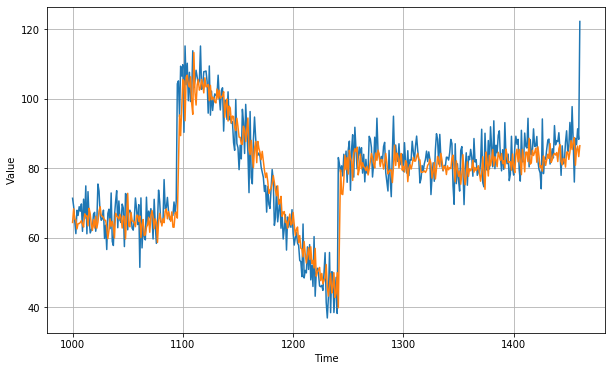

In [0]:
# Predict the next values

forecast = []

# Iterate over the data by passing in a window size of data and predicting the next value
# Do a standard linear regression to get the result: Y = W0*X0 +.... W19*X19 + b
# add to list
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# As data was split into train/valid, take the valid data after the split time to forecast it
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
# MAE is lower than single layer - good but still could be better
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.155049

Let's try again, but with scheduling the learning rate to aid convergence to the minima.

In [0]:
# Remake the dataset and model

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [0]:
# use a LearningRateSchedular Callback to tweak the LR
# Callback reduces the learning rate after each epoch by 10**(epoch / 20)
# starts at 1e-8

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 2424.2082
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 2027.4393
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 1674.8796
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 1330.3969
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 998.8280
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 708.3010
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 499.0412
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 355.9547
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 247.6317
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 183.7766
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 145.7749
Epoch 12/100
31/31 [==============================] - 0s 7ms/step - loss: 127.7636
Epoch 13

[1e-08, 0.001, 0, 300]

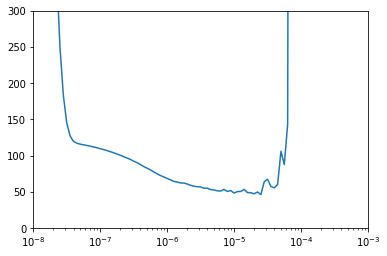

In [0]:
# Plot the loss per epoch vs the learning rate per epoch

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
# now reset the learning rate to the lowest point on the graph and re-train

window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 16ms/step - loss: 128.9763
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 79.3545
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 67.3260
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 63.6738
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 61.9019
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 59.1219
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 56.7004
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 57.0879
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 54.7550
Epoch 10/500
31/31 [==============================] - 0s 8ms/step - loss: 55.2512
Epoch 11/500
31/31 [==============================] - 0s 7ms/step - loss: 52.2992
Epoch 12/500
31/31 [==============================] - 0s 7ms/step - loss: 53.1392
Epoch 13/500
31/31 [===

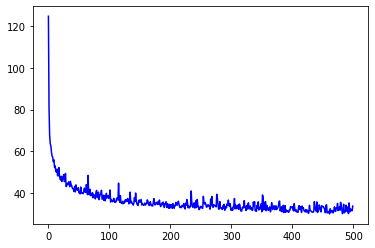

In [0]:
# Plot loss vs epoch
# surely overfitting!

loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[52.25957829583552, 53.02833636568994, 50.391610847551796, 50.07127869989454, 51.45683852520185, 48.26534486750967, 48.23355689294559, 52.24502713704847, 48.70614129292596, 46.759294018302995, 46.235423880508264, 48.02624725656411, 45.517101193457535, 47.619589300253956, 46.83778870572749, 48.843682546713914, 45.470425493692616, 45.93063737141718, 49.41048829383457, 43.08372540031512, 43.52631387612254, 44.59035845097807, 44.067388805900656, 45.336087783341554, 44.658731173485826, 43.019848440111296, 45.58798466318662, 44.24860736807597, 43.65084689032171, 42.50839094181651, 42.07501000866448, 41.871746157616684, 40.74323222956706, 43.181220465591274, 40.51496618211884, 43.90217116837649, 41.81790718393228, 41.40231546225007, 41.286821742893494, 42.588951716472195, 40.13287768413111, 40.21184586987053, 39.53645950789304, 42.89136726929969, 40.086986958611874, 39.87717460553671, 40.028761039812544, 39.66680945366928, 40.902341516239126, 42.33764101008779, 40.51661922808775, 40.302001844

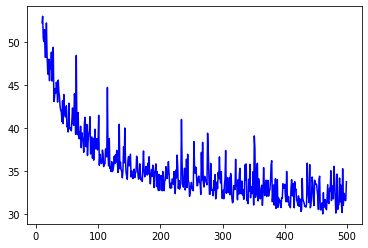

In [0]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

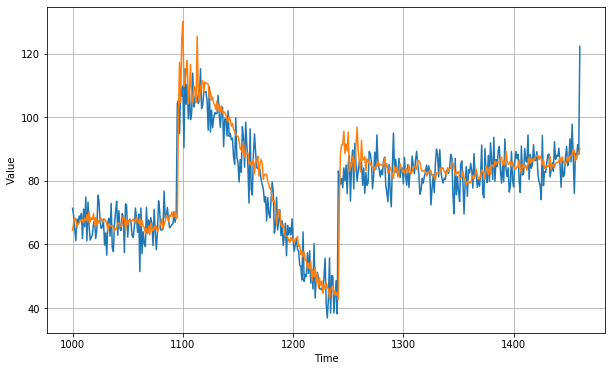

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0918603